In [107]:
#league rules!
numberOfTeams = 10

isFlex = True

ppr = 1
rushYards = .1
receivingYards = .1
rushTD = 6
receivingTD = 6
passYards = 1/25
passTD = 4
fmb = -2
int = -2

In [162]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm

In [47]:
combo2 = pd.read_csv("2023_model_data.csv")
modelData = combo2.drop(columns=["Name", "Unnamed: 0", "team.y", "position.y", "position.x", "team.x", "nextSeasonsTeam", "gsis_id", "team", "name rank", "gsis_id", "team.y", "position.y"])

In [48]:
#label encoding
label_encoders = {}
for column in modelData.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    modelData[column] = le.fit_transform(modelData[column])
    label_encoders[column] = le

In [89]:
season = 2022
train = modelData[modelData["year"] < season]
test = modelData[modelData["year"] == season]
c2_whole = combo2[combo2["year"] == season]
names = c2_whole['Name'].reset_index(drop=True)
positions = c2_whole['position'].reset_index(drop=True)

In [66]:
#data
train_y = train["nextSeasonPAR"]
train_x = train.drop(columns = "nextSeasonPAR", axis = 1)
test_y = test["nextSeasonPAR"]
test_x = test.drop(columns = "nextSeasonPAR", axis = 1)

In [142]:
ntrees = 100

In [ ]:
#train it
ntrees = 100
rf = RandomForestRegressor(n_estimators=ntrees)
rf.fit(train_x, train_y)

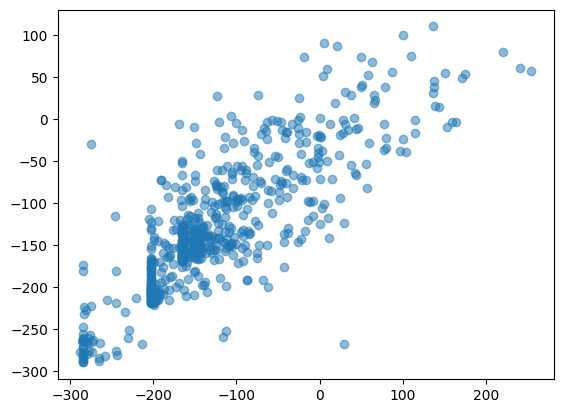

In [51]:
preds = rf.predict(test_x)
plt.scatter(test_y, preds, alpha=.5)

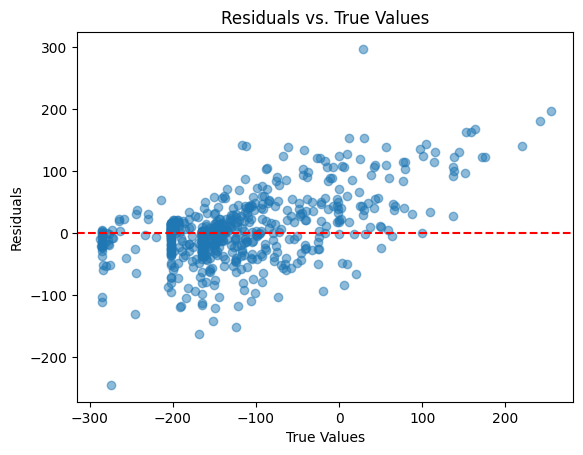

In [53]:
residuals = test_y - preds

# Plot residuals
plt.scatter(test_y, residuals, alpha=0.5)
plt.title('Residuals vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

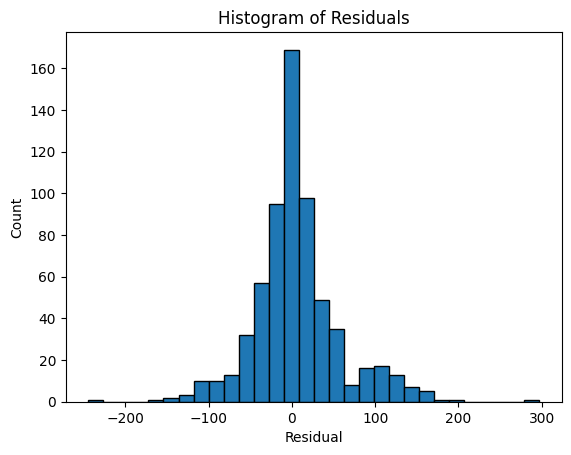

In [54]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

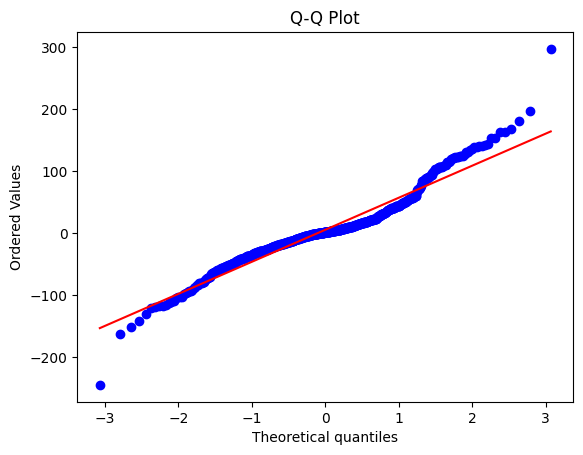

In [55]:
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, rf.predict(test_x))

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

MAE: 36.10048385093167, MSE: 2858.8496156704346, R^2: 0.6740816888952528


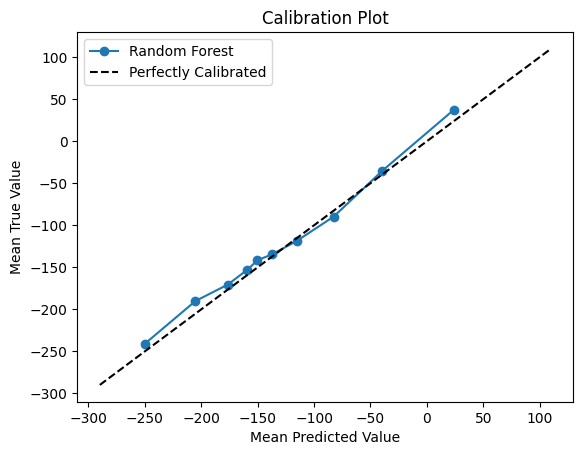

In [58]:
df_calib = pd.DataFrame({'predictions': preds, 'true': test_y})
df_calib['pred_decile'] = pd.qcut(preds, q=10, labels=False)
grouped = df_calib.groupby('pred_decile').mean()

plt.plot(grouped['predictions'], grouped['true'], 'o-', label='Random Forest')
plt.plot([min(preds), max(preds)], [min(preds), max(preds)], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Mean True Value')
plt.title('Calibration Plot')
plt.legend()
plt.show()

In [79]:
#prediction distributions
# Get predictions from each tree in the RandomForestRegressor
tree_predictions = []

for tree in rf.estimators_:
    tree_predictions.append(tree.predict(test_x))

# Convert the predictions to a DataFrame
tree_predictions_df = pd.DataFrame(tree_predictions).transpose()
tree_predictions_df.columns = [f"Tree_{i+1}" for i in range(rf.n_estimators)]

# Display the first few rows of the tree predictions DataFrame
tree_predictions_df.head()

/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X 

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_91,Tree_92,Tree_93,Tree_94,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100
0,218.10,-0.90,76.18,-119.16,163.50,-54.10,154.10,-74.10,152.86,239.86,...,164.00,186.34,203.30,-50.64,-54.10,239.86,92.00,158.00,13.44,-74.10
1,-194.30,57.22,-69.34,-157.66,172.92,0.00,-164.34,-164.34,125.34,81.42,...,57.22,-12.70,30.80,-33.48,-13.50,13.00,84.20,-145.06,-0.94,-145.06
2,125.34,176.94,81.42,97.62,125.72,-171.40,125.34,125.34,-145.06,-140.62,...,57.22,-21.86,18.70,-164.34,102.00,125.72,176.94,125.34,155.66,-157.66
3,-73.38,2.34,-19.94,-287.74,77.56,148.32,36.00,125.72,-106.06,-241.68,...,-287.74,135.12,70.14,135.12,148.32,135.12,135.12,-12.06,-19.94,-57.80
4,-280.70,70.14,29.94,-287.74,0.00,6.72,31.82,31.82,-42.00,89.52,...,-43.26,-38.14,29.94,-260.32,-62.90,135.12,54.96,27.30,2.34,31.82


In [90]:
#include more details in pred dataframe
tree_predictions_df['name'] = names
tree_predictions_df['preds'] = preds
tree_predictions_df['pos'] = positions

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_94,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos
0,218.10,-0.90,76.18,-119.16,163.50,-54.10,154.10,-74.10,152.86,239.86,...,-50.64,-54.10,239.86,92.00,158.00,13.44,-74.10,CooperKupp,59.1624,WR
1,-194.30,57.22,-69.34,-157.66,172.92,0.00,-164.34,-164.34,125.34,81.42,...,-33.48,-13.50,13.00,84.20,-145.06,-0.94,-145.06,JoshAllen,13.8544,QB
2,125.34,176.94,81.42,97.62,125.72,-171.40,125.34,125.34,-145.06,-140.62,...,-164.34,102.00,125.72,176.94,125.34,155.66,-157.66,PatrickMahomes,48.3366,QB
3,-73.38,2.34,-19.94,-287.74,77.56,148.32,36.00,125.72,-106.06,-241.68,...,135.12,148.32,135.12,135.12,-12.06,-19.94,-57.80,MatthewStafford,-6.4930,QB
4,-280.70,70.14,29.94,-287.74,0.00,6.72,31.82,31.82,-42.00,89.52,...,-260.32,-62.90,135.12,54.96,27.30,2.34,31.82,TomBrady,1.0000,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,-242.38,-262.00,-264.84,-287.30,-224.30,-149.60,-275.90,-276.62,-300.76,-256.14,...,-300.36,-276.50,-300.36,-275.90,-275.90,-189.54,-300.36,ChrisStreveler,-260.1758,QB
640,-248.96,-275.90,-241.82,-274.10,-275.90,-177.20,-224.30,-276.62,-300.36,-257.60,...,-292.18,-266.00,-290.54,-171.14,-291.38,-275.90,-241.82,ChadHenne,-227.1960,QB
641,-287.74,-275.90,-275.90,-287.74,-275.90,-177.20,-275.90,-256.86,-241.82,-276.10,...,-256.86,-276.54,-300.36,-261.86,-250.60,-179.80,-254.22,JacobEason,-256.5438,QB
642,-300.36,-276.10,-275.94,-284.26,-275.90,-177.20,-275.90,-263.62,-300.36,-296.82,...,-284.26,-303.72,-300.36,-250.60,-275.90,-275.90,-274.74,FeleipeFranks,-271.1076,QB


In [92]:
#add posrank
# Group by position, sort by RF_Prediction in descending order, then assign a rank within each group
tree_predictions_df['posrank'] = tree_predictions_df.groupby('pos')['preds'].rank(ascending=False, method='min').astype(int)

# Sort the DataFrame based on position and then by Positional_Rank
tree_predictions_df = tree_predictions_df.sort_values(by=['pos', 'posrank'])

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank
7,-13.50,32.52,45.46,71.38,125.72,150.70,-141.98,61.26,13.30,96.50,...,102.00,-145.06,102.00,176.94,30.60,172.92,JustinHerbert,51.2828,QB,1
2,125.34,176.94,81.42,97.62,125.72,-171.40,125.34,125.34,-145.06,-140.62,...,102.00,125.72,176.94,125.34,155.66,-157.66,PatrickMahomes,48.3366,QB,2
1,-194.30,57.22,-69.34,-157.66,172.92,0.00,-164.34,-164.34,125.34,81.42,...,-13.50,13.00,84.20,-145.06,-0.94,-145.06,JoshAllen,13.8544,QB,3
4,-280.70,70.14,29.94,-287.74,0.00,6.72,31.82,31.82,-42.00,89.52,...,-62.90,135.12,54.96,27.30,2.34,31.82,TomBrady,1.0000,QB,4
45,-74.38,-37.12,43.66,-133.30,172.92,70.14,-6.64,-56.70,34.40,-140.62,...,-195.74,-195.74,10.10,-39.36,132.60,-69.76,LamarJackson,-1.9506,QB,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,-220.14,-220.14,-217.14,-219.44,-220.14,-220.14,-220.14,-220.14,-174.64,-220.14,...,-220.14,-220.14,-215.74,-220.14,-220.14,-245.58,MalikTaylor,-218.5208,WR,242
514,-220.14,-216.74,-220.14,-213.74,-220.14,-220.14,-214.14,-220.14,-213.74,-221.36,...,-212.84,-214.14,-220.14,-166.74,-220.14,-175.54,MarcusKemp,-218.6268,WR,243
625,-220.14,-216.42,-220.14,-220.14,-220.14,-192.04,-220.14,-220.14,-220.14,-220.14,...,-200.20,-218.44,-220.14,-220.14,-220.14,-245.58,GeronimoAllison,-218.8862,WR,244
418,-221.36,-220.14,-215.44,-214.54,-220.14,-220.14,-214.54,-215.44,-197.82,-221.36,...,-220.14,-220.14,-217.14,-220.14,-220.14,-216.42,ChrisHogan,-219.5612,WR,245


In [96]:
#make the "individuals" df
individuals = tree_predictions_df.copy()
tree_predictions_df[tree_predictions_df['posrank'] <= 3]

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank
7,-13.50,32.52,45.46,71.38,125.72,150.70,-141.98,61.26,13.30,96.50,...,102.00,-145.06,102.00,176.94,30.60,172.92,JustinHerbert,51.2828,QB,1
2,125.34,176.94,81.42,97.62,125.72,-171.40,125.34,125.34,-145.06,-140.62,...,102.00,125.72,176.94,125.34,155.66,-157.66,PatrickMahomes,48.3366,QB,2
1,-194.30,57.22,-69.34,-157.66,172.92,0.00,-164.34,-164.34,125.34,81.42,...,-13.50,13.00,84.20,-145.06,-0.94,-145.06,JoshAllen,13.8544,QB,3
69,111.50,-136.70,10.60,-155.00,-133.30,32.60,51.40,-14.60,67.80,-0.20,...,163.50,208.10,53.20,67.10,208.60,212.10,DAndreSwift,86.1354,RB,1
13,176.20,171.20,184.50,64.10,81.42,251.70,237.20,212.10,89.82,-71.50,...,256.30,66.90,62.80,62.40,203.30,8.46,AustinEkeler,79.7176,RB,2
12,158.00,150.80,32.60,-71.50,220.40,199.20,-136.70,69.90,47.64,62.80,...,38.20,27.70,-64.60,190.24,113.10,79.46,JoeMixon,74.8790,RB,3
14,239.86,111.30,76.18,22.60,220.40,-162.00,186.34,239.86,81.80,112.40,...,99.60,212.10,149.66,27.66,-155.00,30.08,TravisKelce,60.6240,TE,1
61,90.30,-177.74,3.10,-91.32,7.50,60.46,12.08,48.34,-0.24,-91.32,...,74.00,188.70,55.76,28.26,60.00,7.50,GeorgeKittle,37.4578,TE,2
22,158.00,168.44,21.60,-22.20,8.46,108.40,22.16,168.44,81.80,-209.64,...,76.18,84.20,96.00,130.10,-162.00,-209.64,MarkAndrews,37.4464,TE,3
11,186.34,155.46,76.18,170.18,8.46,-54.10,127.00,158.00,110.10,92.00,...,108.40,186.34,110.10,130.10,13.44,76.96,DavanteAdams,109.7784,WR,1


In [105]:
#make a pred copy df
preds_copy = test_x.reset_index(drop=True).copy()
preds_copy['name'] = names
preds_copy['pos'] = positions
preds_copy['preds'] = preds
preds_copy['adp'] = preds_copy['rank'] * 1.2
preds_copy['adp_sd'] = preds_copy['rank'] * .5 + 1


preds_copy = preds_copy[['name', 'pos', 'rank', 'PAR', 'preds', 'adp', 'adp_sd']]

preds_copy.sort_values(by = 'rank')

,name,pos,rank,PAR,preds,adp,adp_sd
9,JonathanTaylor,RB,1,197.70,73.8214,1.2,1.5
150,ChristianMcCaffrey,RB,2,-45.90,57.2458,2.4,2.0
0,CooperKupp,WR,3,336.86,59.1624,3.6,2.5
13,AustinEkeler,RB,4,172.80,79.7176,4.8,3.0
16,JustinJefferson,WR,5,110.26,53.0040,6.0,3.5
...,...,...,...,...,...,...,...
345,JamesWhite,RB,300,-140.20,-151.0752,360.0,151.0
343,BlakeJarwin,TE,300,-135.70,-135.9092,360.0,151.0
342,MohamedSanu,WR,300,-187.44,-183.0028,360.0,151.0
337,CaseKeenum,QB,300,-242.38,-265.0376,360.0,151.0


In [151]:
#get replacement level player by position
import pandas as pd

# Filtering data based on conditions
replacement_rb = individuals[(individuals['pos'] == 'RB') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_wr = individuals[(individuals['pos'] == 'WR') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_te = individuals[(individuals['pos'] == 'TE') & (individuals['posrank'] == 11)].iloc[:, :ntrees]
replacement_qb = individuals[(individuals['pos'] == 'QB') & (individuals['posrank'] == 11)].iloc[:, :ntrees]

In [108]:
#roundup function
def roundUp(x, to=numberOfTeams):
    return to * (x // to + (x % to > 0))

In [140]:
#your team
draftedOverall = ['JonathanTaylor',
                  'AustinEkeler']

yourTeam = ['JonathanTaylor',
            'AustinEkeler']

In [182]:
# Assuming necessary data is already loaded: individuals, preds_copy, draftedOverall, yourTeam, etc.
# ... [Your data loading code here]

# Initialize DataFrames and lists
createdDataframe = pd.DataFrame()
secondDataframe = pd.DataFrame()
created_rows = []

# Dictionary for positions
pos_dict = {
    'RB': rbs,
    'WR': wrs,
    'TE': tes,
    'QB': qbs
}

# Filter out players in draftedOverall from copy
available = preds_copy[~preds_copy['name'].isin(draftedOverall)]
available = available.sort_values(by=['pos', 'preds'], ascending=False).groupby('pos').head(25).reset_index(drop=True)

for j in range(len(available)):
    player = available.iloc[j]
    name = player['name']
    position = player['pos']

    # Use dictionary to get positional_df
    positional_df = pos_dict[position]

    indi_preds = individuals[(individuals['name'] == name) & (individuals['pos'] == position)].iloc[:, :ntrees].iloc[0]
    total_pt_gains = 0
    pct_better = 0

    for i in range(len(positional_df)):
        row = positional_df.iloc[i]
        better = indi_preds.values > row[::-1].values  # Using values to get numpy arrays
        pct_better = max(pct_better, sum(better) / ntrees)
        avg_pts_gains = np.mean(indi_preds[better].values - np.array(row[::-1])[better])
        total_pt_gains = max(total_pt_gains, pct_better * avg_pts_gains)

    # Finding pick number, your next pick, and the likelihood of a player staying on board
    pickNumber = len(draftedOverall) + 1
    ceiling = roundUp(pickNumber, numberOfTeams)
    leftTillEndOfRound = ceiling - pickNumber
    nextPick = ceiling + leftTillEndOfRound + 1

    # Calculating the chance of staying on board
    chanceOfStayingOnBoard = round(1 - norm.cdf(nextPick, player['adp'], player['adp_sd']), 2)

    # For the round after the likelihood
    ceiling = roundUp(nextPick, numberOfTeams)
    leftTillEndOfRound = ceiling - nextPick
    pickAfter = ceiling + leftTillEndOfRound + 1

    chanceOfStayingOnBoardTwoRounds = 1 - norm.cdf(pickAfter, player['adp'], player['adp_sd'])

    # For the round after...
    ceiling = roundUp(pickAfter, numberOfTeams)
    leftTillEndOfRound = ceiling - pickAfter
    pickEvenAfter = ceiling + leftTillEndOfRound + 1

    chanceOfStayingOnThreeRounds = 1 - norm.cdf(pickEvenAfter, player['adp'], player['adp_sd'])

    # Creating a dictionary to represent the new row
    created_row = {
        'name': player['name'],
        'pos': position,
        'preds': player['preds'],
        'pct_better': pct_better,
        'ADP': player['adp'],
        'total_pt_gains': total_pt_gains,
        'chanceOfStayingOnBoard': chanceOfStayingOnBoard,
        'chanceOfStayingOnBoardTwoRounds': chanceOfStayingOnBoardTwoRounds,
        'chanceOfStayingOnThreeRounds': chanceOfStayingOnThreeRounds
    }
    created_rows.append(created_row)

# Convert the created rows to a DataFrame
createdDataframe = pd.DataFrame(created_rows)

# Process for the second dataframe
second_rows = []

for _, newRow in createdDataframe.iterrows():
    playerPosition = newRow['pos']

    # Filter and sort
    positionallyFiltered = createdDataframe[createdDataframe['pos'] == playerPosition]
    positionallyFiltered = positionallyFiltered.sort_values(by='total_pt_gains', ascending=False).head(12).copy()

    # Initialize new columns
    positionallyFiltered['chance_of_best_option'] = 0
    positionallyFiltered['chance_of_best_option_2'] = 0
    positionallyFiltered['chance_of_best_option_3'] = 0

    for j, row in positionallyFiltered.iterrows():
        better_players = positionallyFiltered[positionallyFiltered['total_pt_gains'] > row['total_pt_gains']]

        # Calculating probabilities for best option next round
        p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoard'])
        p_avail = row['chanceOfStayingOnBoard']
        p_best_option = p_noone_better * p_avail
        positionallyFiltered.at[j, 'chance_of_best_option'] = p_best_option

        # ... for two rounds later
        p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoardTwoRounds'])
        p_avail = row['chanceOfStayingOnBoardTwoRounds']
        p_best_option = p_noone_better * p_avail
        positionallyFiltered.at[j, 'chance_of_best_option_2'] = p_best_option

        # ... and for three rounds later
        p_noone_better = np.prod(1 - better_players['chanceOfStayingOnThreeRounds'])
        p_avail = row['chanceOfStayingOnThreeRounds']
        p_best_option = p_noone_better * p_avail
        positionallyFiltered.at[j, 'chance_of_best_option_3'] = p_best_option

    # Calculating average positional values
    nextRoundValue = np.sum(positionallyFiltered['chance_of_best_option'] * positionallyFiltered['total_pt_gains'])
    nextRoundValue = 1000 if np.isinf(nextRoundValue) or np.isnan(nextRoundValue) else nextRoundValue
    newRow['valueOverNextRound'] = newRow['total_pt_gains'] - nextRoundValue

    valueOverTwoRounds = np.sum(positionallyFiltered['chance_of_best_option_2'] * positionallyFiltered['total_pt_gains'])
    valueOverTwoRounds = 1000 if np.isinf(valueOverTwoRounds) or np.isnan(valueOverTwoRounds) else valueOverTwoRounds
    newRow['valueOverTwoRounds'] = newRow['total_pt_gains'] - valueOverTwoRounds

    valueOverThreeRounds = np.sum(positionallyFiltered['chance_of_best_option_3'] * positionallyFiltered['total_pt_gains'])
    valueOverThreeRounds = 1000 if np.isinf(valueOverThreeRounds) or np.isnan(valueOverThreeRounds) else valueOverThreeRounds
    newRow['valueOverThreeRounds'] = newRow['total_pt_gains'] - valueOverThreeRounds

    second_rows.append(newRow)

secondDataframe = pd.DataFrame(second_rows)

In [183]:
secondDataframe

,name,pos,preds,pct_better,ADP,total_pt_gains,chanceOfStayingOnBoard,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverNextRound,valueOverTwoRounds,valueOverThreeRounds
0,DavanteAdams,WR,109.7784,0.88,13.2,146.3058,0.23,6.581665e-02,6.798549e-05,27.852574,43.988706,65.995778
1,JaMarrChase,WR,100.2332,0.81,7.2,131.4232,0.00,3.907560e-05,6.772360e-15,12.969974,29.106106,51.113178
2,DeeboSamuel,WR,89.6820,0.78,14.4,128.5218,0.30,1.096163e-01,3.738971e-04,10.068574,26.204706,48.211778
3,CooperKupp,WR,59.1624,0.71,3.6,113.6470,0.00,4.218847e-15,0.000000e+00,-4.806226,11.329906,33.336978
4,TyreekHill,WR,54.7202,0.70,20.4,113.6036,0.60,3.921637e-01,3.196759e-02,-4.849626,11.286506,33.293578
...,...,...,...,...,...,...,...,...,...,...,...,...
95,CarsonWentz,QB,-79.3360,0.30,258.0,23.2294,0.99,9.848405e-01,9.787020e-01,-82.432063,-82.223459,-80.802895
96,RyanTannehill,QB,-79.6116,0.30,264.0,27.8324,0.99,9.850409e-01,9.791266e-01,-77.829063,-77.620459,-76.199895
97,DanielJones,QB,-94.1090,0.27,224.4,22.8996,0.99,9.834644e-01,9.757230e-01,-82.761863,-82.553259,-81.132695
98,MattRyan,QB,-98.7434,0.26,291.6,19.4876,0.99,9.858338e-01,9.807834e-01,-86.173863,-85.965259,-84.544695


In [131]:
print(yourDraft['preds'].isnull().sum())


0


In [132]:
print(pd.__version__)


2.0.3


In [137]:
yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min').apply(lambda x: np.int64(x).item())

9    1
Name: preds, dtype: int64

In [138]:
yourDraft

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank,ranked_preds
9,41.2,120.0,67.1,125.0,58.8,-141.2,62.8,7.6,295.2,62.8,...,106.06,251.7,137.5,24.0,150.8,JonathanTaylor,73.8214,RB,4,1
